# Overview

This notebook compares different loss functions for training a 3D segmentation model using MONAI. We focus on three loss function combinations:

1. Pure Dice Loss (Gold Standard)
2. PyDTs HD Loss + Dice Loss (Proposed method)
3. Scipy HD Loss + Dice Loss

The notebook has three main sections:

**Loss Function Timings**

We benchmark the computation timings for each loss function:
1. Pure Dice Loss
2. PyDTs HD Loss
3. Scipy HD Loss

outside of the training loop and in isolation. This helps us understand the computational efficiency of each loss function independently. Results are saved to CSV files.

**Training Loop Timings**

We benchmark the training loop timings for each loss function combination:

1. Pure Dice Loss
2. PyDTs HD Loss + Dice Loss (proposed method)
3. Scipy HD Loss + Dice Loss

We run the training loop for 10 epochs and measure the total training time, average epoch time, and standard deviation of epoch time. This helps us assess the computational efficiency of each loss function combination within the context of a training loop. Results are saved to CSV files.

**Full Training (Accuracy Measurements)**

Based on the timing results from the previous sections, we focus on the two most promising combinations:

1. Pure Dice Loss
2. PyDTs HD Loss + Dice Loss (proposed method)

We run a full training session for each combination, using 600 epochs and evaluating the model on the validation set every 30 epochs. We measure Dice score, Hausdorff distance, and 95th percentile Hausdorff distance.

For each combination, we save the best model based on the validation Dice score, load it, evaluate it using all metrics, and visualize the ground truth label, predicted segmentation, and their boundaries for a validation sample and save all these data points as .csv and .png files.

By comparing the accuracy results, we aim to demonstrate the benefits of incorporating the Hausdorff distance as a loss function.

We use MONAI for data loading, preprocessing, model definition, and evaluation metrics, and `py_distance_transforms` for efficient GPU-based Hausdorff distance computation.

## Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install py_distance_transforms
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.4/397.4 kB 8.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)


**NOTE**: *First time importing `py_distance_transforms` might take a while (~up to 8 mins)*

In [3]:
from py_distance_transforms import transform_cuda
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric, HausdorffDistanceMetric, compute_percent_hausdorff_distance, compute_iou, MeanIoU
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

from scipy.ndimage import distance_transform_edt
import torch.nn.functional as F
import numpy as np
import time
import timeit
import pandas as pd

from juliacall import Main as jl
jl.seval("import CUDA")

# print_config()

[juliapkg] Found dependencies: /usr/local/lib/python3.10/dist-packages/py_distance_transforms/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.10/dist-packages/juliapkg/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.10/dist-packages/juliacall/juliapkg.json
[juliapkg] Locating Julia ~1.9, =1.10.0, ~1.10.3
[juliapkg] Querying Julia versions from https://julialang-s3.julialang.org/bin/versions.json
[juliapkg] WARNING: About to install Julia 1.10.4 to /root/.julia/environments/pyjuliapkg/pyjuliapkg/install.
[juliapkg]   If you use juliapkg in more than one environment, you are likely to
[juliapkg]   have Julia installed in multiple locations. It is recommended to
[juliapkg]   install JuliaUp (https://github.com/JuliaLang/juliaup) or Julia
[juliapkg]   (https://julialang.org/downloads) yourself.
[juliapkg] Downloading Julia from https://julialang-s3.julialang.org/bin/linux/x64/1.10/julia-1.10.4-linux-x86_64.tar.gz
             download complete
[julia

2024-06-28 18:15:30.181979: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-28 18:15:30.234257: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-28 18:15:30.234303: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-28 18:15:30.235864: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-28 18:15:30.244609: I tensorflow/core/platform/cpu_feature_guar

**Setup data directory**

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp0mb0y6wx


**Download dataset**

Downloads and extracts the dataset.  
The dataset comes from http://medicaldecathlon.com/.

In [5]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

Task09_Spleen.tar: 1.50GB [01:54, 14.0MB/s]                            

2024-06-28 18:17:27,871 - INFO - Downloaded: /tmp/tmp0mb0y6wx/Task09_Spleen.tar


2024-06-28 18:17:30,930 - INFO - Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
2024-06-28 18:17:30,931 - INFO - Writing into directory: /tmp/tmp0mb0y6wx.


**Set MSD Spleen dataset path**

In [6]:
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

**Set deterministic training for reproducibility**

In [7]:
set_determinism(seed=0)

**Setup transforms for training and validation**

Here we use several transforms to augment the dataset:
1. `LoadImaged` loads the spleen CT images and labels from NIfTI format files.
1. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
1. `Orientationd` unifies the data orientation based on the affine matrix.
1. `Spacingd` adjusts the spacing by `pixdim=(1.5, 1.5, 2.)` based on the affine matrix.
1. `ScaleIntensityRanged` extracts intensity range [-57, 164] and scales to [0, 1].
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
1. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.
1. `RandAffined` efficiently performs `rotate`, `scale`, `shear`, `translate`, etc. together based on PyTorch affine transform.

In [8]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        )
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


## Check setup in DataLoader

image shape: torch.Size([228, 158, 113]), label shape: torch.Size([228, 158, 113])


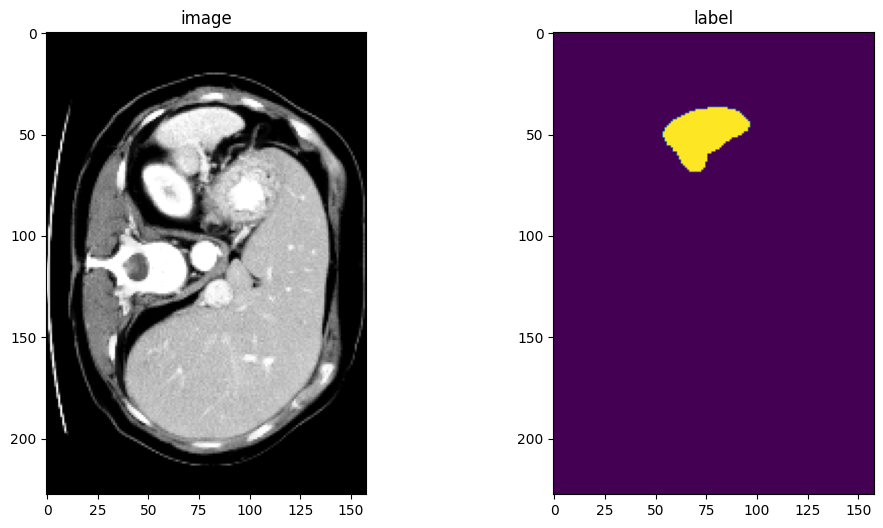

In [9]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()

## CacheDataset

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to to try the regular Dataset, just change to use the commented code below.

In [10]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 9/9 [00:06<00:00,  1.33it/s]


# Loss Function Timings
Write custom losses: [credit](https://github.com/JunMa11/SegWithDistMap/blob/master/code/train_LA_HD.py)

In [11]:
data_path_dir = f"/content/drive/MyDrive/dev/MolloiLab/distance-transforms-paper/data"

In [12]:
np_pred = np.random.choice([0, 1], size=(1, 1, 224, 224, 112)).astype(np.float32)
np_label = np.random.choice([0, 1], size=(1, 1, 224, 224, 112)).astype(np.float32)

torch_pred = torch.tensor(np_pred).cuda()
torch_label = torch.tensor(np_label).cuda()

## Dice Loss

In [13]:
dice_loss = DiceLoss(to_onehot_y=False, softmax=False)

In [14]:
%%timeit
dice_loss(torch_pred, torch_label)

392 µs ± 76.5 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [15]:
import statistics

In [16]:
# Number of runs
number = 5
repeat = 10

In [17]:
# Use timeit.repeat to get multiple timing results
times_dice = timeit.repeat(lambda: dice_loss(torch_pred, torch_label), number=7, repeat=number)

In [18]:
# Calculate statistics
min_dice, std_dice = min(times_dice), statistics.stdev(times_dice)
min_dice, std_dice # seconds

(0.001286239000137357, 0.0005553864347083228)

## Scipy HD Loss

In [19]:
def compute_dtm(img_gt, out_shape):
    """
    compute the distance transform map of foreground in binary mask
    input: segmentation, shape = (batch_size, x, y, z)
    output: the foreground Distance Map (SDM)
    dtm(x) = 0; x in segmentation boundary
             inf|x-y|; x in segmentation
    """

    fg_dtm = np.zeros(out_shape)

    for b in range(out_shape[0]): # batch size
        for c in range(1, out_shape[1]):
            posmask = img_gt[b].astype(bool)
            if posmask.any():
                posdis = distance_transform_edt(posmask)
                fg_dtm[b][c] = posdis

    return fg_dtm

In [20]:
def hd_loss(seg_soft, gt, seg_dtm, gt_dtm):
    """
    compute huasdorff distance loss for binary segmentation
    input: seg_soft: softmax results,  shape=(b,2,x,y,z)
           gt: ground truth, shape=(b,x,y,z)
           seg_dtm: segmentation distance transform map; shape=(b,2,x,y,z)
           gt_dtm: ground truth distance transform map; shape=(b,2,x,y,z)
    output: boundary_loss; sclar
    """

    delta_s = (seg_soft[:,1,...] - gt.float()) ** 2
    s_dtm = seg_dtm[:,1,...] ** 2
    g_dtm = gt_dtm[:,1,...] ** 2
    dtm = s_dtm + g_dtm

    multipled = torch.einsum('bxyz, bxyz->bxyz', delta_s, dtm)
    hd_loss = multipled.mean()

    return hd_loss

In [21]:
# Convert torch_pred to shape (b, 2, x, y, z) for softmax output
torch_pred_soft = torch.stack((1 - torch_pred, torch_pred), dim=1).squeeze(2)

In [22]:
def time_hd_loss_scipy():
  gt_dtm_npy = compute_dtm(torch_label.cpu().numpy(), torch_pred_soft.shape)
  gt_dtm = torch.from_numpy(gt_dtm_npy).float().cuda(torch_pred_soft.device.index)
  seg_dtm_npy = compute_dtm(torch_pred_soft[:, 1, :, :, :].cpu().numpy() > 0.5, torch_pred_soft.shape)
  seg_dtm = torch.from_numpy(seg_dtm_npy).float().cuda(torch_pred_soft.device.index)

  hd_loss(torch_pred_soft, torch_label[:, 0, :, :, :], seg_dtm, gt_dtm)

In [23]:
times_hd_scipy = timeit.repeat(lambda: time_hd_loss_scipy(), number=number, repeat=repeat)

In [24]:
# Calculate statistics
min_hd_scipy, std_hd_scipy = min(times_hd_scipy), statistics.stdev(times_hd_scipy)
min_hd_scipy, std_hd_scipy # seconds

(16.21868726699995, 0.23432210304542378)

## PyDTs HD Loss (Proposed)

In [25]:
def compute_dtm_gpu(img_gt, out_shape):
    """
    compute the distance transform map of foreground in binary mask
    input: segmentation, shape = (batch_size, x, y, z)
    output: the foreground Distance Map (SDM)
    dtm(x) = 0; x in segmentation boundary
             inf|x-y|; x in segmentation
    """

    # Convert img_gt to float if not already float
    if img_gt.dtype != torch.float32:
        img_gt = img_gt.float()

    fg_dtm = torch.zeros(out_shape, dtype=torch.float32, device=img_gt.device)

    for b in range(out_shape[0]):  # batch size
        for c in range(1, out_shape[1]):
            posmask = img_gt[b]
            if posmask.bool().any():
                posdis = transform_cuda(posmask)
                fg_dtm[b, c] = posdis

    return fg_dtm.to(img_gt.dtype)

In [26]:
def time_hd_loss_pydt():
  gt_dtm = compute_dtm_gpu(torch_label, torch_pred_soft.shape)
  seg_dtm = compute_dtm_gpu(torch_pred_soft[:, 1, :, :, :] > 0.5, torch_pred_soft.shape)
  hd_loss(torch_pred_soft, torch_label[:, 0, :, :, :], seg_dtm, gt_dtm)

In [27]:
times_hd_pydt = timeit.repeat(lambda: time_hd_loss_pydt(), number=number, repeat=repeat)

In [ ]:
jl.seval("CUDA.GC.gc(true); CUDA.reclaim()") # IMPORTANT, otherwise GPU RAM can overflow

In [28]:
# Calculate statistics
min_hd_pydt, std_hd_pydt = min(times_hd_pydt[1:-1]), statistics.stdev(times_hd_pydt[1:-1])
min_hd_pydt, std_hd_pydt # seconds

(0.02617953200001466, 0.0004845163863793632)

In [29]:
# Create a dictionary with the results
results = {
    'Loss Function': ['Dice Loss', 'HD Loss (SciPy)', 'HD Loss (PyDT)'],
    'Minimum Time (s)': [min_dice, min_hd_scipy, min_hd_pydt],
    'Standard Deviation (s)': [std_dice, std_hd_scipy, std_hd_pydt]
}

# Create the DataFrame
df_pure_losses = pd.DataFrame(results)

# Set 'Loss Function' as the index
df_pure_losses = df_pure_losses.set_index('Loss Function')

# Format the numbers to 6 decimal places
# df_pure_losses = df_pure_losses.applymap(lambda x: f"{x:.6f}")

# Display the DataFrame
print(df_pure_losses)

                 Minimum Time (s)  Standard Deviation (s)
Loss Function                                            
Dice Loss                0.001286                0.000555
HD Loss (SciPy)         16.218687                0.234322
HD Loss (PyDT)           0.026180                0.000485


In [30]:
# Save the DataFrame as a CSV file
df_pure_losses_path = f"{data_path_dir}/hd_loss_pure_losses_timings.csv"
df_pure_losses.to_csv(df_pure_losses_path)

# Training Loop Timings

In [31]:
dice_loss = DiceLoss(to_onehot_y=True, softmax=True)

## Pure Dice Loss (Gold Standard)

In [32]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

max_epochs = 10
model_data = []
epoch_loss_values = []
epoch_times = []

for epoch in range(max_epochs):
    start_time = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = dice_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    end_time = time.time()
    epoch_time = end_time - start_time
    epoch_times.append(epoch_time)
    print(f"Epoch {epoch + 1} training time: {epoch_time:.2f} seconds")

# Print total training time, average time per epoch, and standard deviation
total_training_time = sum(epoch_times)
avg_epoch_time = np.mean(epoch_times)
std_epoch_time = np.std(epoch_times)
print(f"\nTotal training time: {total_training_time:.2f} seconds")
print(f"Average training time per epoch: {avg_epoch_time:.2f} seconds")
print(f"Standard deviation of training time per epoch: {std_epoch_time:.2f} seconds")

# Append the model's details and timings to the list
model_data.append({
    'Model': 'Plain Dice Loss',
    'Total Training Time (s)': total_training_time,
    'Avg Epoch Time (s)': avg_epoch_time,
    'Std Epoch Time (s)': std_epoch_time
})

# Create a DataFrame from the model_data list
df_plain_dice = pd.DataFrame(model_data)

# Save the DataFrame as a CSV file
df_dice_path = f"{data_path_dir}/hd_loss_plain_dice_timing.csv"
df_plain_dice.to_csv(df_dice_path)

----------
epoch 1/10


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch 1 average loss: 0.6564
Epoch 1 training time: 5.20 seconds
----------
epoch 2/10
epoch 2 average loss: 0.6301
Epoch 2 training time: 4.89 seconds
----------
epoch 3/10
epoch 3 average loss: 0.6089
Epoch 3 training time: 4.53 seconds
----------
epoch 4/10
epoch 4 average loss: 0.5950
Epoch 4 training time: 4.83 seconds
----------
epoch 5/10
epoch 5 average loss: 0.5868
Epoch 5 training time: 4.65 seconds
----------
epoch 6/10
epoch 6 average loss: 0.5783
Epoch 6 training time: 4.64 seconds
----------
epoch 7/10
epoch 7 average loss: 0.5624
Epoch 7 training time: 4.55 seconds
----------
epoch 8/10
epoch 8 average loss: 0.5531
Epoch 8 training time: 4.92 seconds
----------
epoch 9/10
epoch 9 average loss: 0.5472
Epoch 9 training time: 4.63 seconds
----------
epoch 10/10
epoch 10 average loss: 0.5439
Epoch 10 training time: 4.71 seconds

Total training time: 47.55 seconds
Average training time per epoch: 4.76 seconds
Standard deviation of training time per epoch: 0.20 seconds


In [33]:
torch.cuda.empty_cache()

## Scipy HD Loss + Dice Loss

Run this for only 10 epochs, just to showcase the difference in training speed. Accuracy differences between `scipy.ndimage.distance_transform_edt` and `py_distance_transforms.transform_cuda` should be neglible

In [34]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

max_epochs = 10
model_data = []
epoch_loss_values = []
epoch_times = []

alpha = 1.0

for epoch in range(max_epochs):
    start_time = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss_seg_dice = dice_loss(outputs, labels)
        outputs_soft = F.softmax(outputs, dim=1)

        with torch.no_grad():
            gt_dtm_npy = compute_dtm(labels.cpu().numpy(), outputs_soft.shape)
            gt_dtm = torch.from_numpy(gt_dtm_npy).float().cuda(outputs_soft.device.index)
            seg_dtm_npy = compute_dtm(outputs_soft[:, 1, :, :, :].cpu().numpy()>0.5, outputs_soft.shape)
            seg_dtm = torch.from_numpy(seg_dtm_npy).float().cuda(outputs_soft.device.index)

        loss_hd = hd_loss(outputs_soft, labels[:, 0, :, :, :], seg_dtm, gt_dtm)
        loss = alpha*loss_seg_dice + (1 - alpha) * loss_hd
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    end_time = time.time()
    epoch_time = end_time - start_time
    epoch_times.append(epoch_time)
    print(f"Epoch {epoch + 1} training time: {epoch_time:.2f} seconds")

    alpha -= 0.001
    if alpha <= 0.001:
        alpha = 0.001

# Print total training time, average time per epoch, and standard deviation
total_training_time = sum(epoch_times)
avg_epoch_time = np.mean(epoch_times)
std_epoch_time = np.std(epoch_times)
print(f"\nTotal training time: {total_training_time:.2f} seconds")
print(f"Average training time per epoch: {avg_epoch_time:.2f} seconds")
print(f"Standard deviation of training time per epoch: {std_epoch_time:.2f} seconds")

# Append the model's details and timings to the list
model_data.append({
    'Model': 'Scipy HD Loss + Dice Loss',
    'Total Training Time (s)': total_training_time,
    'Avg Epoch Time (s)': avg_epoch_time,
    'Std Epoch Time (s)': std_epoch_time
})

# Create a DataFrame from the model_data list
df_hd_dice_scipy = pd.DataFrame(model_data)

# Save the DataFrame as a CSV file
df_hd_dice_scipy_path = f"{data_path_dir}/hd_loss_hd_dice_scipy_timing.csv"
df_hd_dice_scipy.to_csv(df_hd_dice_scipy_path)

----------
epoch 1/10
epoch 1 average loss: 0.6313
Epoch 1 training time: 45.66 seconds
----------
epoch 2/10
epoch 2 average loss: 0.6119
Epoch 2 training time: 43.61 seconds
----------
epoch 3/10
epoch 3 average loss: 0.5947
Epoch 3 training time: 46.23 seconds
----------
epoch 4/10
epoch 4 average loss: 0.5851
Epoch 4 training time: 45.31 seconds
----------
epoch 5/10
epoch 5 average loss: 0.5766
Epoch 5 training time: 46.31 seconds
----------
epoch 6/10
epoch 6 average loss: 0.5683
Epoch 6 training time: 44.85 seconds
----------
epoch 7/10
epoch 7 average loss: 0.5593
Epoch 7 training time: 46.63 seconds
----------
epoch 8/10
epoch 8 average loss: 0.5555
Epoch 8 training time: 43.61 seconds
----------
epoch 9/10
epoch 9 average loss: 0.5528
Epoch 9 training time: 42.60 seconds
----------
epoch 10/10
epoch 10 average loss: 0.5398
Epoch 10 training time: 44.18 seconds

Total training time: 448.99 seconds
Average training time per epoch: 44.90 seconds
Standard deviation of training ti

In [35]:
torch.cuda.empty_cache()
torch.cuda.empty_cache()
torch.cuda.empty_cache()

## PyDTs HD Loss + Dice Loss (Proposed)

In [36]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

max_epochs = 10
model_data = []
epoch_loss_values = []
epoch_times = []

alpha = 1.0

for epoch in range(max_epochs):
    start_time = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss_seg_dice = dice_loss(outputs, labels)
        outputs_soft = F.softmax(outputs, dim=1)

        with torch.no_grad():
            gt_dtm = compute_dtm_gpu(labels, outputs_soft.shape)
            seg_dtm = compute_dtm_gpu(outputs_soft[:, 1, :, :, :]>0.5, outputs_soft.shape)

        loss_hd = hd_loss(outputs_soft, labels[:, 0, :, :, :], seg_dtm, gt_dtm)
        loss = alpha*loss_seg_dice + (1 - alpha) * loss_hd
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    jl.seval("CUDA.GC.gc(true); CUDA.reclaim()") # IMPORTANT, otherwise GPU RAM overflows, not a huge slowdown penalty either
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    end_time = time.time()
    epoch_time = end_time - start_time
    epoch_times.append(epoch_time)
    print(f"Epoch {epoch + 1} training time: {epoch_time:.2f} seconds")

    alpha -= 0.001
    if alpha <= 0.001:
        alpha = 0.001

# Print total training time, average time per epoch, and standard deviation
total_training_time = sum(epoch_times)
avg_epoch_time = np.mean(epoch_times)
std_epoch_time = np.std(epoch_times)
print(f"\nTotal training time: {total_training_time:.2f} seconds")
print(f"Average training time per epoch: {avg_epoch_time:.2f} seconds")
print(f"Standard deviation of training time per epoch: {std_epoch_time:.2f} seconds")

# Append the model's details and timings to the list
model_data.append({
    'Model': 'PyDTs HD Loss + Dice Loss',
    'Total Training Time (s)': total_training_time,
    'Avg Epoch Time (s)': avg_epoch_time,
    'Std Epoch Time (s)': std_epoch_time
})

# Create a DataFrame from the model_data list
df_hd_dice_pydt = pd.DataFrame(model_data)

# Save the DataFrame as a CSV file
df_hd_dice_pydt_path = f"{data_path_dir}/hd_loss_hd_dice_pydt_timing.csv"
df_hd_dice_pydt.to_csv(df_hd_dice_pydt_path)

----------
epoch 1/10
epoch 1 average loss: 0.6265
Epoch 1 training time: 6.68 seconds
----------
epoch 2/10
epoch 2 average loss: 0.6202
Epoch 2 training time: 5.70 seconds
----------
epoch 3/10
epoch 3 average loss: 0.6060
Epoch 3 training time: 5.69 seconds
----------
epoch 4/10
epoch 4 average loss: 0.5918
Epoch 4 training time: 5.61 seconds
----------
epoch 5/10
epoch 5 average loss: 0.7359
Epoch 5 training time: 5.80 seconds
----------
epoch 6/10
epoch 6 average loss: 0.6300
Epoch 6 training time: 6.48 seconds
----------
epoch 7/10
epoch 7 average loss: 0.6084
Epoch 7 training time: 5.59 seconds
----------
epoch 8/10
epoch 8 average loss: 0.6337
Epoch 8 training time: 5.81 seconds
----------
epoch 9/10
epoch 9 average loss: 0.6376
Epoch 9 training time: 5.76 seconds
----------
epoch 10/10
epoch 10 average loss: 0.5830
Epoch 10 training time: 5.76 seconds

Total training time: 58.88 seconds
Average training time per epoch: 5.89 seconds
Standard deviation of training time per epoch

In [37]:
torch.cuda.empty_cache()

# Full Training (Accuracy Measurements)
Now that we have run all three loss function combos:

1. Pure dice loss
2. Dice loss + pydt hausdorff loss
3. Dice loss + scipy hausdorff loss

Let's now focus on the two fastest, pure dice loss and dice loss + pydt hausdorff loss, and run a full training. The combination of hd loss plus dice should be more powerful than pure dice. But, this needs to be tested fully. Let's look at just these two and run for 600 epochs, then lets save the best model and metrics. Finally we will visualize the ground truth label and the prediction and their boundaries, for each model

In [38]:
# Create metric objects
dice_metric = DiceMetric(include_background=False, reduction="mean")
hausdorff_metric = HausdorffDistanceMetric(include_background=False, reduction="mean")
hausdorff_95_metric = HausdorffDistanceMetric(include_background=False, percentile=95, reduction="mean")
iou_metric = MeanIoU(include_background=False, reduction="mean")

## Pure Dice Loss (Gold Standard)

In [51]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

max_epochs = 600
val_interval = 5
best_metric = -1
best_metric_epoch = -1
model_data = []
epoch_loss_values = []
val_loss_values = []
metric_values = []
epoch_times = []
epoch_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

dice_loss = DiceLoss(include_background=False, to_onehot_y=True, softmax=True)
dice_metric = DiceMetric(include_background=False, reduction="mean")

start_time = time.time()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    epoch_start = time.time()
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = dice_loss(outputs, labels)

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    epoch_values.append(epoch + 1)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_steps = 0
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)

                # Compute validation loss
                val_loss += dice_loss(val_outputs, val_labels).item()
                val_steps += 1

                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]

                # Compute Dice metric
                dice_metric(y_pred=val_outputs, y=val_labels)

            # Aggregate the final validation loss and Dice metric results
            val_loss /= val_steps
            val_loss_values.append(val_loss)
            dice_score = dice_metric.aggregate().item()

            # Reset the status for next validation round
            dice_metric.reset()

            metric_values.append(dice_score)
            if dice_score > best_metric:
                best_metric = dice_score
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(data_path_dir, "best_metric_model_dice.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {dice_score:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )
            print(f"validation loss: {val_loss:.4f}")

    epoch_time = time.time() - epoch_start
    epoch_times.append(epoch_time)
    print(f"time consumed in epoch {epoch + 1}: {epoch_time:.2f}s")

total_time = time.time() - start_time
print(f"Total training time: {total_time:.2f}s")

----------
epoch 1/600


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch 1 average loss: 0.9219
time consumed in epoch 1: 4.87s
----------
epoch 2/600
epoch 2 average loss: 0.8982
time consumed in epoch 2: 4.98s
----------
epoch 3/600
epoch 3 average loss: 0.8695
time consumed in epoch 3: 4.81s
----------
epoch 4/600
epoch 4 average loss: 0.8690
time consumed in epoch 4: 5.40s
----------
epoch 5/600
epoch 5 average loss: 0.8482
saved new best metric model
current epoch: 5 current mean dice: 0.0648
best mean dice: 0.0648 at epoch: 5
validation loss: 0.9609
time consumed in epoch 5: 8.41s
----------
epoch 6/600
epoch 6 average loss: 0.8356
time consumed in epoch 6: 5.04s
----------
epoch 7/600
epoch 7 average loss: 0.8242
time consumed in epoch 7: 4.92s
----------
epoch 8/600
epoch 8 average loss: 0.8038
time consumed in epoch 8: 4.82s
----------
epoch 9/600
epoch 9 average loss: 0.7756
time consumed in epoch 9: 4.82s
----------
epoch 10/600
epoch 10 average loss: 0.7530
current epoch: 10 current mean dice: 0.0183
best mean dice: 0.0648 at epoch: 5
vali

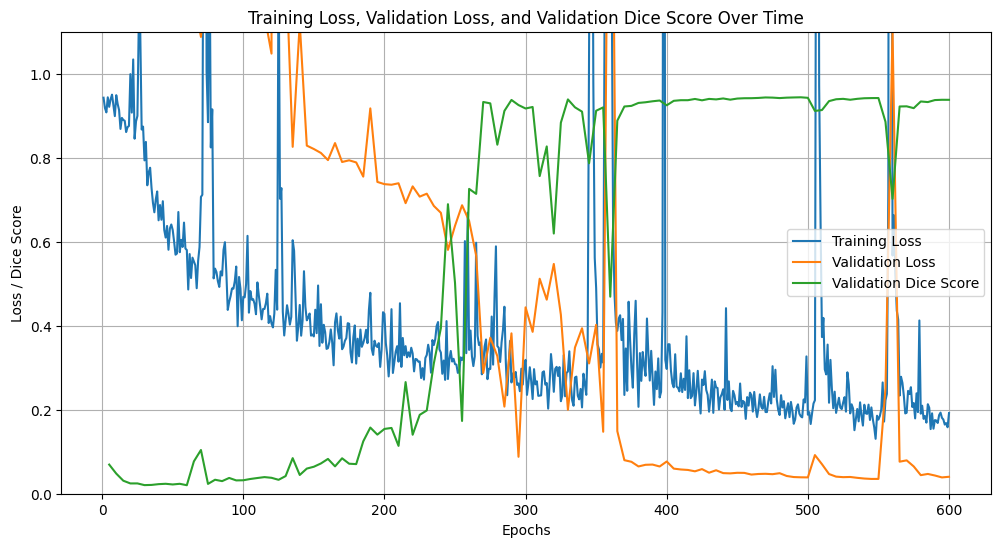

In [68]:
# After the training loop, create and show the plot
plt.figure(figsize=(12, 6))
plt.plot(epoch_values, epoch_loss_values, label='Training Loss')
plt.plot(range(val_interval, len(val_loss_values) * val_interval + 1, val_interval), val_loss_values, label='Validation Loss')
plt.plot(range(val_interval, len(metric_values) * val_interval + 1, val_interval), metric_values, label='Validation Dice Score')
plt.xlabel('Epochs')
plt.ylabel('Loss / Dice Score')
plt.title('Training Loss, Validation Loss, and Validation Dice Score Over Time')
plt.legend()
plt.grid(True)
plt.ylim(0, 1.1)  # This line clamps the y-axis from 0 to 1
plt.show()

In [53]:
# Save the training results as a DataFrame/CSV
df = pd.DataFrame({
    'Epoch': epoch_values,
    'Training Loss': epoch_loss_values,
    'Validation Loss': [val_loss_values[i // val_interval] if i % val_interval == 0 else None for i in range(max_epochs)],
    'Validation Dice Score': [metric_values[i // val_interval] if i % val_interval == 0 else None for i in range(max_epochs)],
    'Epoch Time (s)': epoch_times
})

# Fill NaN values in 'Validation Loss' and 'Validation Dice Score' columns with previous values
df['Validation Loss'] = df['Validation Loss'].fillna(method='ffill')
df['Validation Dice Score'] = df['Validation Dice Score'].fillna(method='ffill')

# Add total training time to the DataFrame
df.loc[len(df)] = ['Total', None, None, None, total_time]

# Save the DataFrame as a CSV file
csv_path = os.path.join(data_path_dir, "training_results_dice.csv")
df.to_csv(csv_path, index=False)

print(f"Training completed. Results saved as '{csv_path}'")

Training completed. Results saved as '/content/drive/MyDrive/dev/MolloiLab/distance-transforms-paper/data/training_results_dice.csv'


In [54]:
# Load the saved best model
best_model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
best_model.load_state_dict(torch.load(os.path.join(data_path_dir, "best_metric_model_dice.pth")))

# Evaluate the best model on the validation set using all metrics
best_model.eval()
with torch.no_grad():
    for val_data in val_loader:
        val_inputs, val_labels = (
            val_data["image"].to(device),
            val_data["label"].to(device),
        )
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, best_model)
        val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
        val_labels = [post_label(i) for i in decollate_batch(val_labels)]

        # Compute metrics for the best model
        dice_metric(y_pred=val_outputs, y=val_labels)
        hausdorff_metric(y_pred=val_outputs, y=val_labels)
        hausdorff_95_metric(y_pred=val_outputs, y=val_labels)
        iou_metric(y_pred=val_outputs, y=val_labels)

    # Aggregate the final metric results for the best model
    dice_score = dice_metric.aggregate().item()
    hausdorff_distance = hausdorff_metric.aggregate().item()
    hausdorff_distance_95 = hausdorff_95_metric.aggregate().item()
    iou_score = iou_metric.aggregate().item()

# Append the best model's details and metrics to the list
model_data.append({
    'Model': 'Plain Dice Loss',
    'Best Epoch': best_metric_epoch,
    'Dice Score': dice_score,
    'Hausdorff Distance': hausdorff_distance,
    '95 Percentile Hausdorff Distance': hausdorff_distance_95,
    'IoU Score': iou_score,
    'Total Training Time (s)': total_training_time,
    'Avg Epoch Time (s)': avg_epoch_time,
    'Std Epoch Time (s)': std_epoch_time
})

# Create a DataFrame from the model_data list
df_plain_dice = pd.DataFrame(model_data)

# Save the DataFrame as a CSV file
df_dice_path = os.path.join(data_path_dir, "hd_loss_metrics_dice.csv")
df_plain_dice.to_csv(df_dice_path)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [55]:
df_plain_dice

,Model,Best Epoch,Dice Score,Hausdorff Distance,95 Percentile Hausdorff Distance,IoU Score,Total Training Time (s),Avg Epoch Time (s),Std Epoch Time (s)
0,Plain Dice Loss,435,0.891513,168.115997,120.334801,0.296326,58.880946,7.770342,1.808379


In [56]:
torch.cuda.empty_cache()

## PyDTs HD Loss + Dice Loss (Proposed)

In [57]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

max_epochs = 600
val_interval = 5
best_metric = -1
best_metric_epoch = -1
model_data = []
epoch_loss_values = []
val_loss_values = []
metric_values = []
epoch_times = []
epoch_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

dice_loss = DiceLoss(include_background=False, to_onehot_y=True, softmax=True)
dice_metric = DiceMetric(include_background=False, reduction="mean")

# Define alpha for the combined loss
alpha = 1.0

start_time = time.time()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    epoch_start = time.time()
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)

        ## ---- START CUSTOM LOSS ---- ##
        loss_seg_dice = dice_loss(outputs, labels)
        outputs_soft = F.softmax(outputs, dim=1)

        with torch.no_grad():
            gt_dtm = compute_dtm_gpu(labels, outputs_soft.shape)
            seg_dtm = compute_dtm_gpu(outputs_soft[:, 1, :, :, :] > 0.5, outputs_soft.shape)

        loss_hd = hd_loss(outputs_soft, labels[:, 0, :, :, :], seg_dtm, gt_dtm)
        loss = alpha * loss_seg_dice + (1 - alpha) * loss_hd
        ## ---- END CUSTOM LOSS ---- ##

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    epoch_values.append(epoch + 1)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_steps = 0
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)

                # Compute validation loss
                val_outputs_soft = F.softmax(val_outputs, dim=1)
                val_loss_seg_dice = dice_loss(val_outputs, val_labels)
                val_gt_dtm = compute_dtm_gpu(val_labels, val_outputs_soft.shape)
                val_seg_dtm = compute_dtm_gpu(val_outputs_soft[:, 1, :, :, :] > 0.5, val_outputs_soft.shape)
                val_loss_hd = hd_loss(val_outputs_soft, val_labels[:, 0, :, :, :], val_seg_dtm, val_gt_dtm)
                val_loss += (alpha * val_loss_seg_dice + (1 - alpha) * val_loss_hd).item()
                val_steps += 1

                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]

                # Compute Dice metric
                dice_metric(y_pred=val_outputs, y=val_labels)

            # Aggregate the final validation loss and Dice metric results
            val_loss /= val_steps
            val_loss_values.append(val_loss)
            dice_score = dice_metric.aggregate().item()

            # Reset the status for next validation round
            dice_metric.reset()

            metric_values.append(dice_score)
            if dice_score > best_metric:
                best_metric = dice_score
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(data_path_dir, "best_metric_model_hd_pydt.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {dice_score:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )
            print(f"validation loss: {val_loss:.4f}")

    jl.seval("CUDA.GC.gc(true); CUDA.reclaim()") # IMPORTANT, otherwise GPU RAM overflows, not a huge slowdown penalty either
    epoch_time = time.time() - epoch_start
    epoch_times.append(epoch_time)
    print(f"time consumed in epoch {epoch + 1}: {epoch_time:.2f}s")

    alpha -= 0.001
    if alpha <= 0.001:
        alpha = 0.001

total_time = time.time() - start_time
print(f"Total training time: {total_time:.2f}s")

----------
epoch 1/600


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch 1 average loss: 0.9429
time consumed in epoch 1: 5.75s
----------
epoch 2/600
epoch 2 average loss: 0.9181
time consumed in epoch 2: 5.96s
----------
epoch 3/600
epoch 3 average loss: 0.9079
time consumed in epoch 3: 5.89s
----------
epoch 4/600
epoch 4 average loss: 0.9438
time consumed in epoch 4: 6.24s
----------
epoch 5/600
epoch 5 average loss: 0.9212
saved new best metric model
current epoch: 5 current mean dice: 0.0694
best mean dice: 0.0694 at epoch: 5
validation loss: 1.7628
time consumed in epoch 5: 9.53s
----------
epoch 6/600
epoch 6 average loss: 0.9392
time consumed in epoch 6: 6.10s
----------
epoch 7/600
epoch 7 average loss: 0.9502
time consumed in epoch 7: 5.98s
----------
epoch 8/600
epoch 8 average loss: 0.9240
time consumed in epoch 8: 5.95s
----------
epoch 9/600
epoch 9 average loss: 0.8990
time consumed in epoch 9: 5.84s
----------
epoch 10/600
epoch 10 average loss: 0.9489
current epoch: 10 current mean dice: 0.0479
best mean dice: 0.0694 at epoch: 5
vali

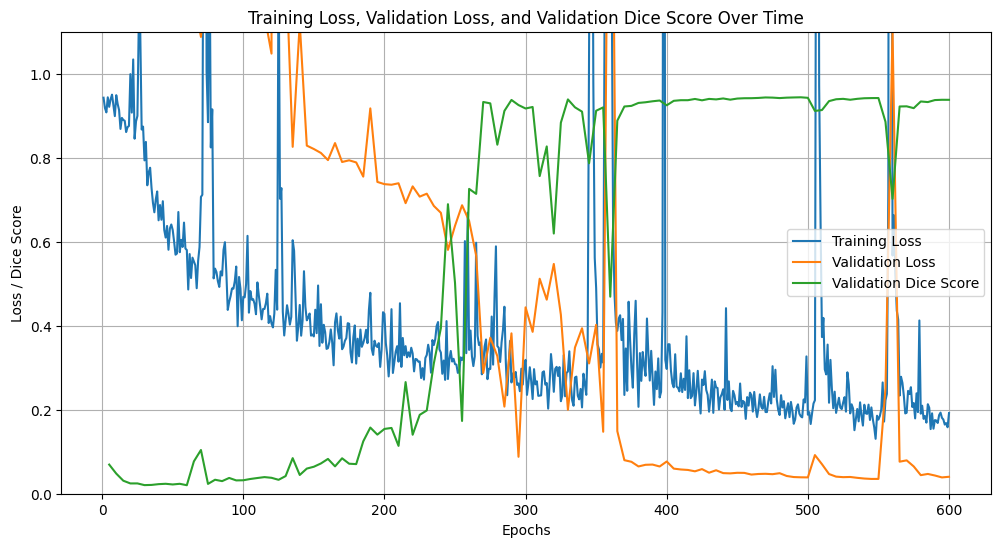

In [67]:
# After the training loop, create and show the plot
plt.figure(figsize=(12, 6))
plt.plot(epoch_values, epoch_loss_values, label='Training Loss')
plt.plot(range(val_interval, len(val_loss_values) * val_interval + 1, val_interval), val_loss_values, label='Validation Loss')
plt.plot(range(val_interval, len(metric_values) * val_interval + 1, val_interval), metric_values, label='Validation Dice Score')
plt.xlabel('Epochs')
plt.ylabel('Loss / Dice Score')
plt.title('Training Loss, Validation Loss, and Validation Dice Score Over Time')
plt.legend()
plt.grid(True)
plt.ylim(0, 1.1)  # This line clamps the y-axis from 0 to 1
plt.show()

In [59]:
jl.seval("CUDA.GC.gc(true); CUDA.reclaim()") # IMPORTANT, otherwise GPU RAM overflows, not a huge slowdown penalty either

In [60]:
torch.cuda.empty_cache()

In [61]:
# Save the training results as a DataFrame/CSV
df = pd.DataFrame({
    'Epoch': epoch_values,
    'Training Loss': epoch_loss_values,
    'Validation Loss': [val_loss_values[i // val_interval] if i % val_interval == 0 else None for i in range(max_epochs)],
    'Validation Dice Score': [metric_values[i // val_interval] if i % val_interval == 0 else None for i in range(max_epochs)],
    'Epoch Time (s)': epoch_times
})

# Fill NaN values in 'Validation Loss' and 'Validation Dice Score' columns with previous values
df['Validation Loss'] = df['Validation Loss'].fillna(method='ffill')
df['Validation Dice Score'] = df['Validation Dice Score'].fillna(method='ffill')

# Add total training time to the DataFrame
df.loc[len(df)] = ['Total', None, None, None, total_time]

# Save the DataFrame as a CSV file
csv_path = os.path.join(data_path_dir, "training_results_hd_pydt.csv")
df.to_csv(csv_path, index=False)

print(f"Training completed. Results saved as '{csv_path}'")

Training completed. Results saved as '/content/drive/MyDrive/dev/MolloiLab/distance-transforms-paper/data/training_results_hd_pydt.csv'


In [62]:
# Load the saved best model
best_model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
best_model.load_state_dict(torch.load(os.path.join(data_path_dir, "best_metric_model_hd_pydt.pth")))

# Evaluate the best model on the validation set using all metrics
best_model.eval()
with torch.no_grad():
    for val_data in val_loader:
        val_inputs, val_labels = (
            val_data["image"].to(device),
            val_data["label"].to(device),
        )
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, best_model)
        val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
        val_labels = [post_label(i) for i in decollate_batch(val_labels)]

        # Compute metrics for the best model
        dice_metric(y_pred=val_outputs, y=val_labels)
        hausdorff_metric(y_pred=val_outputs, y=val_labels)
        hausdorff_95_metric(y_pred=val_outputs, y=val_labels)
        iou_metric(y_pred=val_outputs, y=val_labels)

    # Aggregate the final metric results for the best model
    dice_score = dice_metric.aggregate().item()
    hausdorff_distance = hausdorff_metric.aggregate().item()
    hausdorff_distance_95 = hausdorff_95_metric.aggregate().item()
    iou_score = iou_metric.aggregate().item()

# Calculate average and standard deviation of epoch times
avg_epoch_time = np.mean(epoch_times)
std_epoch_time = np.std(epoch_times)

# Append the best model's details and metrics to the list
model_data.append({
    'Model': 'HD Loss + Dice Loss',
    'Best Epoch': best_metric_epoch,
    'Dice Score': dice_score,
    'Hausdorff Distance': hausdorff_distance,
    '95 Percentile Hausdorff Distance': hausdorff_distance_95,
    'IoU Score': iou_score,
    'Total Training Time (s)': total_time,
    'Avg Epoch Time (s)': avg_epoch_time,
    'Std Epoch Time (s)': std_epoch_time
})

# Create a DataFrame from the model_data list
df_hd_dice = pd.DataFrame(model_data)

# Save the DataFrame as a CSV file
csv_path = os.path.join(data_path_dir, "training_results_dice.csv")
df.to_csv(csv_path, index=False)

print(f"Training completed. Results saved as '{csv_path}'")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training completed. Results saved as '/content/drive/MyDrive/dev/MolloiLab/distance-transforms-paper/data/training_results_dice.csv'


In [63]:
df_hd_dice

,Model,Best Epoch,Dice Score,Hausdorff Distance,95 Percentile Hausdorff Distance,IoU Score,Total Training Time (s),Avg Epoch Time (s),Std Epoch Time (s)
0,HD Loss + Dice Loss,495,0.943885,135.34343,92.693687,0.445893,4013.967917,6.689501,1.449937


In [64]:
df_plain_dice

,Model,Best Epoch,Dice Score,Hausdorff Distance,95 Percentile Hausdorff Distance,IoU Score,Total Training Time (s),Avg Epoch Time (s),Std Epoch Time (s)
0,Plain Dice Loss,435,0.891513,168.115997,120.334801,0.296326,58.880946,7.770342,1.808379


In [ ]:
# df_plain_dice["Total Training Time"] = 3385.87s

## Qualitative Comparison

In [70]:
# Load the best models
best_model_dice = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
best_model_dice.load_state_dict(torch.load(os.path.join(data_path_dir, "best_metric_model_dice.pth")))

best_model_hd_dice = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
best_model_hd_dice.load_state_dict(torch.load(os.path.join(data_path_dir, "best_metric_model_hd_pydt.pth")))

# Set the models to evaluation mode
best_model_dice.eval()
best_model_hd_dice.eval();

In [124]:
import os

# Specify the desired slices
slice_nums = [66, 67, 69, 88, 89, 90]

# Create a directory to save the images
output_dir = os.path.join(data_path_dir, "slice_images")
os.makedirs(output_dir, exist_ok=True)

with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        if i == 3:
            break

        # Get the input image and label
        image = val_data["image"].to(device)
        label = val_data["label"].to(device)

        roi_size = (160, 160, 160)
        sw_batch_size = 4

        # Get the model outputs
        output_dice = sliding_window_inference(image, roi_size, sw_batch_size, best_model_dice)
        output_hd_dice = sliding_window_inference(image, roi_size, sw_batch_size, best_model_hd_dice)

        for slice_num in slice_nums:
            # Convert the outputs to binary masks
            mask_dice = torch.argmax(output_dice, dim=1).detach().cpu().numpy()[0, :, :, slice_num]
            mask_hd_dice = torch.argmax(output_hd_dice, dim=1).detach().cpu().numpy()[0, :, :, slice_num]

            # Convert the label to a binary mask
            label_mask = label.detach().cpu().numpy()[0, 0, :, :, slice_num]

            # Create a figure without axes
            fig, ax = plt.subplots(figsize=(8, 8))  # Increase figure size
            ax.axis('off')

            # Display the input image
            ax.imshow(image.detach().cpu().numpy()[0, 0, :, :, slice_num], cmap="gray", interpolation='lanczos')  # Apply interpolation

            # Save the input image
            plt.savefig(os.path.join(output_dir, f"input_image_{i+1}_slice_{slice_num}.png"), dpi=600, bbox_inches='tight', pad_inches=0)  # Increase dpi
            plt.close(fig)

            # Create a figure without axes
            fig, ax = plt.subplots(figsize=(8, 8))  # Increase figure size
            ax.axis('off')

            # Display the label mask
            ax.imshow(label_mask, cmap="gray", interpolation='lanczos')  # Apply interpolation

            # Save the label mask
            plt.savefig(os.path.join(output_dir, f"label_mask_{i+1}_slice_{slice_num}.png"), dpi=600, bbox_inches='tight', pad_inches=0)  # Increase dpi
            plt.close(fig)

            # Create a figure without axes
            fig, ax = plt.subplots(figsize=(8, 8))  # Increase figure size
            ax.axis('off')

            # Display the label mask with predicted contours
            ax.imshow(label_mask, cmap="gray", interpolation='lanczos')  # Apply interpolation
            ax.contour(mask_hd_dice, colors="green", linewidths=1)
            ax.contour(mask_dice, colors="red", linewidths=1, linestyles=':')

            # Save the label mask with predicted contours
            plt.savefig(os.path.join(output_dir, f"predictions_{i+1}_slice_{slice_num}.png"), dpi=600, bbox_inches='tight', pad_inches=0)  # Increase dpi
            plt.close(fig)